In [2]:
# This is version 3.10 for smFISH spot detection. I have tried using pycharm + other python platform but in the end I feel like using Jupyter notebook is more suitable 
# Especailly for person who enter the Planarian Field might not understand coding/structure and other things too much. 
# This requires a enviornment and setting parameters. 
# https://stackoverflow.com/questions/58645807/change-interpreter-in-jupyter-notebook Please refer to this for setting up python interpreter. 
# This requires setting up a enviornment for 3D detection on stardist and bigfish. 
# Recommend to setup a enviornment for Stardist and then install bigfish/fishquant. 
# Please read instructions from Stardist to do so, and set python interpreter using the stackoverflow instructions. 
# Depend on your Image and settings this whole code need a while to run. I am making it as light as possible so please be patient. 
# I am also using tqdm in all of my customized code to show you process and the expected time in real time. 
# Please contact qingxuguan2020@u.northwestern.edu for any details/updates/help. 

In [3]:
# Here I will put most of the varaibles need for running python 
# File path: This will include: A control channel for checking intensities and other parameters
# If there is no control channel, please change controlImage = False
# counterstainChannelPath for smFISH channel, the signal you want to segement in this case 
# nucleiChannelPath for the nuclei channel locations 
# assuming you are running 3D detection. If not please develop a separate code for this. 
controlImage = True 
counterstainControlPath = "/Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/control/6h_Incision_Image2/633/control_6h_Incision_Image2_633.tif"
counterstainChannelPath = "/Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/633/6h_Amputation_Image2_633.tif"
nucleiSegmentationPath = "/Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/565/results/labels"
# Set Parameters for detection. Here minimal distance is the minimal distance between spots. 
# Note this will be consistent for both control and the smFISH channel. 
# Unless specified separately, all these three number tuples are z,y,x in order. 
minimal_distance = (2,2,2)
# Set the Gaussian LoG filter Kernel size. Recommend to start with 1,1.5,1.5 and increase if you need more. 
# I don`t think you need this different from control and experimental image. 
kernel_size = (1,1.5,1.5)
# Set the voxel size. This is determined by the pixel size of your microscope. Please contact microscopt manufactuer and convert resolution to voxel size. 
# unit is nm, please change to nm and note this should be the same for control and your experimental image. 
# I specifically allow this code to run different voxel size for control and experimental image, but for a good experiment you should not do it like that. 
control_voxel_size = (361,75,75)
voxel_size = (361,75,75)
# Set the spot size as your expected spot size 
spot_size = (600, 300, 300)
decomposition_thresh = (0.7,1,5)
# Recommend start with 4 in planarian. You can have more. Recommend turn spotsRadiusDetection = True and run the radius test
# Usually the largest radius/the average radius is what you want. 
min_spots_for_clusters = 4
# Enter the radius for spot for detecting clusters. 
# If need refer to the spotsRadiusDetection to set a good reference
radius_for_spots = 250 
# Here you need to define the spot plotting size You can make it as large as possible. 
plot_spot_size = 4
# Here you add the nuclei projection size 


In [4]:
# Here we get some advanced settings: 
# Spot_radius detections
# automated False, turn to True if you need the code to detect a correct average spotRadius, in pixels for you. 
spotsRadiusDetection = True
# Lets see if you want to save the Spot infomation. I turn it to True by default, but in general you dont need to do that. 
saveSpotInformation = True 
# Lets set this for Plotting Outer Circle. 
# If you want to plot Inner Circle Please set this to False 
plotInnerCircle = False 
# If you need to plot exact spot location, turn this to True. In this case the plot_spot_size will be rendered off since there is no need for plotting spot size. 
# Note this function is still under development. Please, be aware and I dont recommend turn it on. 
plotExactSpot = False
# Adjust the outer layer size here if you need 
exactSpotSize = 2
# Open this if you want to plot each spot by number. I do not recommend turn this on since this will largely increase the image size and does not help with anything. 
# If you need this note you need to have at most 65536 spots. If you have more manually change the dtype in the empty image but I dont think anyone need this much of image. 
plotSpotLabel = False 
labelExpansionSize = 20
nuclei_projection_size = 10

In [5]:
counterstainAverageThreshold = 9.50
counterstainControlAverageThreshold = 8.29

In [6]:
# This part is for importing all the functions for smFISH detection. Please install them if you dont have these pacakges. 
import os
import sys
# import tk for getting the directory faster. dont need this in a command line/server version
import tkinter as tk
from tkinter import *
from tkinter import filedialog
import numpy as np
import bigfish.detection 
import bigfish.stack
import bigfish.plot
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import random
import math
import json
# if you dont need to plot in jupyter you don need these. Some magic interperters need to be removed for command line version. 
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Glob and tifffile are needed
from glob import glob
from tifffile import imread,imwrite
# csb deep is to take normalization 
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible
# This is your stardist models and everything in stardist coming from. 
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from skimage import segmentation
import bigfish.multistack as multistack
# Set random seed for you color map. You do not really need this to be 6 all the time, but its okay. 
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [7]:
# This part is for functions used in smFISH detection. Please run this before you run any code below. 
# This block is for selecting filepath and read in file
def select_path(current_path, dialog_title):
    """
    Opens a file dialog if the current_path is None, otherwise returns the current_path.
    """
    if current_path is None:
        root = tk.Tk()
        root.withdraw()  # Hide the main window
        file_path = filedialog.askopenfilename(title=dialog_title)
        root.destroy()  # Destroy the main window
        return file_path
    else:
        return current_path
# Selecte your directory
def select_folder(dialogtitle):
    root = tk.Tk()
    root.withdraw()  # Hide the root window

    folder_selected = filedialog.askdirectory(title = dialogtitle )
    
    root.destroy()  # Close the root window

    if folder_selected:
        print(f"Selected model folder: {folder_selected}")
        return folder_selected
    else:
        print("No folder selected")
        return None
# Create a results folder in the file path. 
def create_folder_in_same_directory(file_path, folder_name):
    """
    Creates a folder with the specified name in the same directory as the given file.
    If the folder already exists, it returns the existing path.
    """
    # Get the directory of the given file
    directory = os.path.dirname(file_path)
    
    # Define the path for the specified folder
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder exists
    if not os.path.exists(folder_path):
        # Create the folder if it doesn't exist
        os.makedirs(folder_path)
        print(f"Created '{folder_name}' folder at: {folder_path}")
    else:
        print(f"'{folder_name}' folder already exists at: {folder_path}")
    
    return folder_path
# Functions used for find spots 
# Used these method to validate the method. 
# validArray = imread('/Users/eliasguan/Desktop/EG_stardist_segmentation/022523_smFISH_analysis_v2.0_development/Weekly_Reports/2024Spring/061724/Test_expand_function/Test_9_21_validation.tif')
# spot = find_spots_around((15-9,5,3), validArray, max_iterations = 10)
def find_spots_around(coordinate, array, max_iterations = 10):
    """
    Find all spots around the given coordinate in a 3D array until reaching a value of 0.
    input: coordinate: the coordinate of the spot 
           array: The image array, please us the LoG filtered image
    Output: a List of all array found around the coordinate 
    """
    
    # Start with outer_edge only containing this one single point
    outer_edge = [np.array(coordinate,dtype = np.uint16)]
    export_outer_edge = []
    # Start with the spot collection only containing this one single point
    spots_collection = [np.array(coordinate,dtype = np.uint16)]
    # Set up array shape 
    shape = array.shape
    # Go through max iteration numbers 
    for i in range(max_iterations):
        # Set up new outer edge at the start, and replace the old outer edge with this on the next round 
        new_outer_edge = []
        flag = False 
        counter = 0
        # Iterate through all items in outer_edge
        for item in outer_edge:
            # Keep the length of the current outeredge
            # Fist see if coordinate in this item is greater than 1, if it is 0 you can not iterate to the left.
            if item[2]>=1:
                # if possible assign left 
                left = np.array([item[0],item[1],item[2]-1],dtype = np.int16)
                # Check if the point in the image is greater than 0, if it is 0 it will not be in the spot collection
                # Here I have three tests: First, if the spot is alreay in the collection. This avoids backsearching 
                # Second, if the spot is greater than 0 This means you reach an edge then you should immediately stop searching in this direction
                # Third, if the spot is greater than the original spot. This avoids accidentally meeting a second spot in the same area. 
                # If all these checks are met, add the spot to the left into both outer edge, and the spot collection. 
                if sum(np.array_equal(point_outer_edge, left) for point_outer_edge in spots_collection) == 0 and array[left[0],left[1],left[2]] > 0 and array[item[0],item[1],item[2]] >= array[left[0],left[1],left[2]]: 
                    # If this pass we add this point to the new outer edge 
                    # If this pass we add this point to the spots collection 
                    new_outer_edge.append(left)
                    spots_collection.append(left)
            # Then see if coordinate in this item is to the right edge of the image. If it is this case you can not iterate to the right
            if item[2]+1 <= shape[2]-1:
                right = np.array([item[0],item[1],item[2]+1],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, right) for point_outer_edge in spots_collection) == 0 and array[right[0],right[1],right[2]] > 0 and array[item[0],item[1],item[2]] >= array[right[0],right[1],right[2]]:
                    # If this pass we add this point to the new outer edge 
                    # If this pass we add this point to the spots collection 
                    new_outer_edge.append(right)
                    spots_collection.append(right)
            # Do exact same thing for Up and down: 
            if item[1]>=1:
                up = np.array([item[0],item[1]-1,item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, up) for point_outer_edge in spots_collection) == 0 and array[up[0],up[1],up[2]] > 0 and array[item[0],item[1],item[2]] >= array[up[0],up[1],up[2]]:
                    new_outer_edge.append(up)
                    spots_collection.append(up)
            if item[1]+1 <=shape[1]-1:
                down = np.array([item[0],item[1]+1,item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, down) for point_outer_edge in spots_collection) == 0 and array[down[0],down[1],down[2]] > 0 and array[item[0],item[1],item[2]] >= array[down[0],down[1],down[2]]:
                    new_outer_edge.append(down)
                    spots_collection.append(down)
            # Do exact the same thing for top and bottom 
            if item[0]>=1:
                top = np.array([item[0]-1,item[1],item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, top) for point_outer_edge in spots_collection) == 0 and array[top[0],top[1],top[2]] > 0 and array[item[0],item[1],item[2]] >= array[top[0],top[1],top[2]]:
                    new_outer_edge.append(top)
                    spots_collection.append(top)
            if item[0]+1 <= shape[0]-1:
                bottom = np.array([item[0]+1,item[1],item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, bottom) for point_outer_edge in spots_collection) == 0 and array[bottom[0],bottom[1],bottom[2]] > 0 and array[item[0],item[1],item[2]] >= array[bottom[0],bottom[1],bottom[2]]:
                    new_outer_edge.append(bottom)
                    spots_collection.append(bottom)
            # Check if your new outer edge is empty. In this case you can not expand anyfurther so just break it. 
            if len(new_outer_edge) == 0: 
                flag = True
                break 
            # Here it is the end of inner loop 
        # If flag is changed break the outloop as well       
        if flag == True: 
            break 
        # If you have other points in the new outer edge then you need to replace the old outer edge with the new outer edge. 
        else:
            outer_edge = new_outer_edge
    # Export your results 
    return np.array(spots_collection)
# Finding the outer edge of a spots collection. Need to be further validate and develop. Please be patient. 
def find_outer_edge (spots_collection, shape, max_iterations = 2):
    """ Function: Find outer edge. 
        Input: spots_collection: A collection of spots. This requires to be generated by the previous function or it need to be a set of spots connecting to each other. 
               shape: The shape of origininal array. 
               max_iteration: How many times iteration you want 
        Output: The outer edge of the spot collection 
    """
    outer_edge = []
    inner_spot = spots_collection
    for i in range(max_iterations):
        for item in inner_spot:
            # We just follow our pervious function but do not check very hard in this case: 
            if item[2]>=1:
            # if possible assign left 
                left = np.array([item[0],item[1],item[2]-1],dtype = np.uint16)
                # If left is not in the inner spot collection, it should be in outer edge and add to inner spot
                if sum(np.array_equal(point_outer_edge, left) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,left)
                    outer_edge.append(left)
            # else if this spot is not in the outer_edge, add the spot to outer_edge
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                outer_edge.append(item)
        
            if item[2]+1 <= shape[2]-1:
            # if possible assign right
                right = np.array([item[0],item[1],item[2]+1],dtype = np.uint16)
                # If right is not in the inner spot collection, it should be in outer edge and add to inner spot
                if sum(np.array_equal(point_outer_edge, right) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,right)
                    outer_edge.append(right)
            # else if this spot is not in the outer_edge, add the spot to outer_edge
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                outer_edge.append(item)
            # Do the same thing for Up and down
            if item[1]>=1:
                up = np.array([item[0],item[1]-1,item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, up) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,up)
                    outer_edge.append(up)
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                    outer_edge.append(item)
            if item[1]+1 <= shape[1]-1:
                down = np.array([item[0],item[1]+1,item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, down) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,down)
                    outer_edge.append(down)
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                outer_edge.append(item)
            if item[0]>=1:
                top= np.array([item[0]-1,item[1],item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge, top) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,top)
                    outer_edge.append(top)
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                outer_edge.append(item)
            if item[0]+1 <= shape[0]-1:
                bottom= np.array([item[0]+1,item[1],item[2]],dtype = np.uint16)
                if sum(np.array_equal(point_outer_edge,bottom) for point_outer_edge in inner_spot) == 0:
                    np.append(inner_spot,bottom)
                    outer_edge.append(bottom)
            elif sum(np.array_equal(point_outer_edge, item) for point_outer_edge in outer_edge) == 0:
                outer_edge.append(item)
    return np.array(outer_edge)
# Find plot around in 2D to make spot plot 
def generate_coordinates_2D(y, x, shape, iteration =4, get_inner_spot = False):
    # Initial collection with the starting coordinate (x, y)
    coordinates_collection = [(y, x)]
    max_y = (shape[0]-1)
    max_x = (shape[1]-1)

    for _ in range(iteration):
        # Copy the current collection to avoid modifying it while iterating
        current_coordinates = coordinates_collection.copy()

        # Loop through each coordinate in the current collection
        for coord in current_coordinates:
            # Extract x and y values from the coordinate
            cy, cx = coord

            # Add neighboring coordinates to the collection if within bounds
            if cx + 1 <= max_x:
                coordinates_collection.append((cy,cx+1))
            if 0 <= cx - 1:
                coordinates_collection.append((cy,cx-1))
            if cy + 1 < max_y:
                coordinates_collection.append((cy+1, cx))
            if 0 <= cy - 1:
                coordinates_collection.append((cy-1, cx))

    # Remove duplicates by converting the list to a set and then back to a list
    coordinates_collection = list(set(coordinates_collection))
    if get_inner_spot:
        return coordinates_collection
    else:
        coordinates_collection = [coord for coord in coordinates_collection if abs(coord[0] - y) + abs(coord[1] - x) == iteration]
        return coordinates_collection
def generate_max_projection_array(array, projection_size):
    ranges = []
    total = array.shape[0]
    projected_image = []
    for i in range(0, total, projection_size):
        start = i
        end = min(i + projection_size - 1, total - 1)
        ranges.append((start, end))
    for item in ranges:
        start, end = item
        nuclei_array = []
        for i in range(start,end):
            nuclei_array.append(array[i])
        projection = bigfish.stack.maximum_projection(np.array(nuclei_array,dtype=np.uint8))
        projected_image.append(projection)
    return np.array(projected_image,dtype=np.uint8)



In [8]:
# Check and select paths if they are None
# Run this block to select your file path. If you already entered the path, then it will return the path you entered. 
# Make sure your path is corrrect. This is the file the program will load. 
if controlImage:
    counterstainControlPath = select_path(counterstainControlPath, "Select Control Path")
if not counterstainChannelPath:
    counterstainChannelPath = select_path(counterstainChannelPath, "Select smFISH Channel Path")
if not nucleiSegmentationPath:
    nucleiSegmentationPath = select_path(nucleiChannelPath, "Select Nuclei Channel Path")
# Print the selected paths
print(f"Control Path: {counterstainControlPath}")
print(f"smFISH Channel Path: {counterstainChannelPath}")
if controlImage:
    print(f"Segmented Nuclei Path: {nucleiSegmentationPath}")
# Create location for results 
resultsPath = create_folder_in_same_directory(counterstainChannelPath,'results')

Control Path: /Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/control/6h_Incision_Image2/633/control_6h_Incision_Image2_633.tif
smFISH Channel Path: /Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/633/6h_Amputation_Image2_633.tif
Segmented Nuclei Path: /Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/565/results/labels
'results' folder already exists at: /Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/633/results


Created 'results/Control' folder at: /Users/eliasguan/Desktop/EG_0920_Test_wnt1_incision_amputation/Experiment_dataset/Experiment/6h_Amputation/Image2/633/results/Control


100%|█████████████████████████████████████| 13547/13547 [19:48<00:00, 11.40it/s]


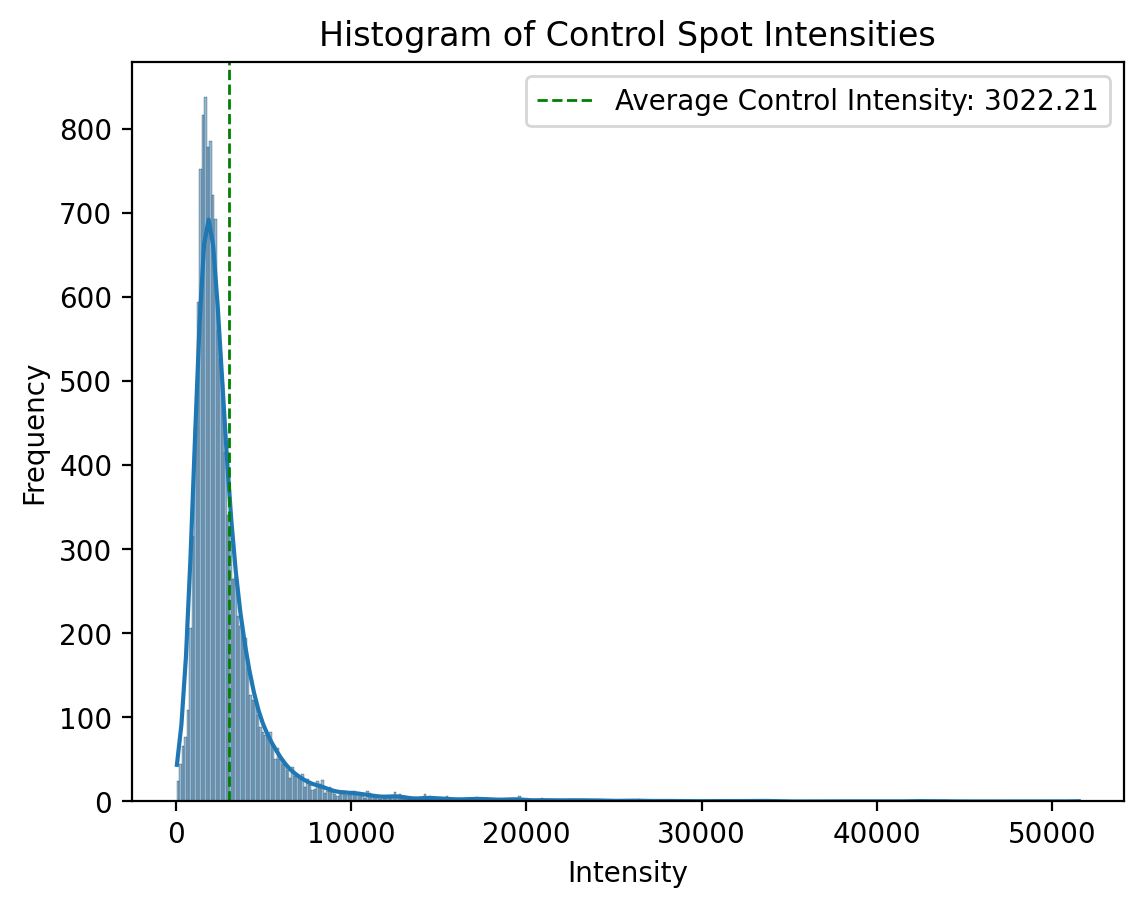

In [9]:
# Part 1: Read in control data and calculate the parameteres et.c
# if there is no control data this part will be skipped 
if controlImage:
    # Get the LoG and Localmax filter for getting the spot intensities 
    # Change path to the working directory
    os.chdir(os.path.dirname(counterstainChannelPath))
    controlResultsPath = create_folder_in_same_directory(file_path = counterstainChannelPath, folder_name = "results/Control")
    os.chdir(controlResultsPath)
    # Read in your Control Array 
    controlArray = imread(counterstainControlPath)
    # Generate Local max filter and LoG filtered Image 
    controlArray_LoG = bigfish.stack.log_filter(controlArray, kernel_size)
    # Save the image and remove unrelated images 
    imwrite('controlArray_LoG.tif', controlArray_LoG, photometric='minisblack')
    # Here run the spot detection on Control image 
    control_spots, control_threshold = bigfish.detection.detect_spots(
        images=controlArray,
        threshold = counterstainControlAverageThreshold,
        return_threshold=True,
        voxel_size= control_voxel_size,  # in nanometer (one value per dimension zyx)
        spot_radius= spot_size, # in nanometer (one value per dimension zyx)
        log_kernel_size= kernel_size,
        minimum_distance= minimal_distance)
    # Then you need to find each spot location by using some other algrtihm. 
    controlSpotIntensityCollection = []
    # Here find the intensity sum for each spot detected in control set up: 
    for i in tqdm(range(len(control_spots))):
        # Find all the spots, max_iteration use 5 is enough for each condition. For safety I will use around 10 
        # By practice in the 64 X64 X361 voxel size, a real spot is around 5-6 pixel in radius. 
        spots_around = find_spots_around(control_spots[i],controlArray_LoG, max_iterations = 10)
        # Set your intensity 
        intensity = 0
        for item in spots_around:
            # Find your spot intensity in original array 
            intensity = intensity+controlArray[item[0],item[1],item[2]]
        # Add your intensity to the list and then go to the next round 
        controlSpotIntensityCollection.append(intensity)
    avgControlSpotIntensity = np.mean(controlSpotIntensityCollection)
    # Create a histogram plot
    sns.histplot(controlSpotIntensityCollection, kde=True)
    # Add labels and title
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Control Spot Intensities')
    # Add the average value 
    plt.axvline(avgControlSpotIntensity, color='g', linestyle='--', linewidth=1, label=f'Average Control Intensity: {avgControlSpotIntensity:.2f}')
    plt.legend()
    # Show the plot
    plt.savefig('histogram_of_control_spot_intensities.png')
    plt.show()
    del controlArray, controlArray_LoG, control_spots 

In [10]:
# Part 2 run the detection for the real spots. 
os.chdir(os.path.dirname(counterstainChannelPath))
# Note here we are woking in results folder
os.chdir('results')
os.getcwd()
smFISHChannelArray = imread(counterstainChannelPath)
# Get your log filter and write it in the results folder 
smFISHChannelArray_LoG = bigfish.stack.log_filter(smFISHChannelArray, kernel_size)
imwrite('smFISHChannelArray_LoG.tif', smFISHChannelArray_LoG, photometric='minisblack')
# Get detection of your spots 
smFISH_spots, smFISH_threshold = bigfish.detection.detect_spots(
        images=smFISHChannelArray,
        threshold = counterstainAverageThreshold,
        return_threshold=True,
        voxel_size= voxel_size,  # in nanometer (one value per dimension zyx)
        spot_radius= spot_size, # in nanometer (one value per dimension zyx)
        log_kernel_size= kernel_size,
        minimum_distance= minimal_distance)
# Get the elbow curve and threshold 
bigfish.plot.plot_elbow(
        images=smFISHChannelArray,
        voxel_size=voxel_size,
        spot_radius=spot_size,
        path_output="Elbow.png",
        show=False)
# Save the spots here for future works. 
np.save('spots.npy', smFISH_spots)
# here we list some properties of your detected spots. 
print("detected spots")
print("\r shape: {0}".format(smFISH_spots.shape))
print("\r dtype: {0}".format(smFISH_spots.dtype))
print("\r threshold: {0}".format(smFISH_threshold))
if saveSpotInformation == True:
     with open ("spot_info.txt","w") as file :
        file.write("\r shape: {0}".format(smFISH_spots.shape))
        file.write("\r dtype: {0}".format(smFISH_spots.dtype))
        file.write("\r threshold: {0}".format(smFISH_threshold))

detected spots
 shape: (64896, 3)
 dtype: int64
 threshold: 9.5


100%|███████████████████████████████████| 64896/64896 [2:24:43<00:00,  7.47it/s]


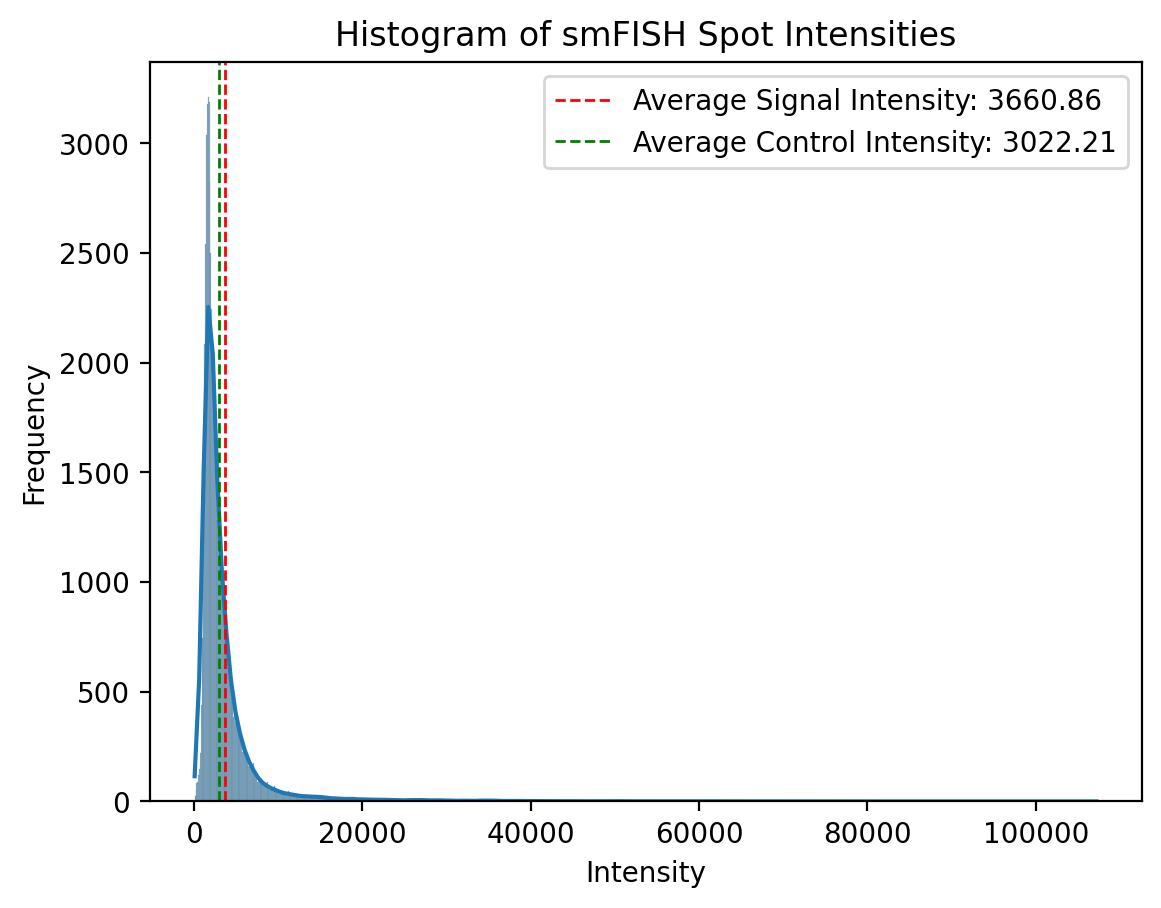

In [11]:
# Get your Average Spot intensity and compare to the 
smFISHSpotIntensityCollection = []
for i in tqdm(range(len(smFISH_spots))):
    # Find all the spots, max_iteration use 5 is enough for each condition. For safety I will use 6 
    spots_around = find_spots_around(smFISH_spots[i],smFISHChannelArray_LoG, max_iterations = 20)
    # Set your intensity 
    intensity = 0
    for item in spots_around:
        # Find your spot intensity in original array 
        intensity = intensity+smFISHChannelArray[item[0],item[1],item[2]]
    # Add your intensity to the list and then go to the next round 
    smFISHSpotIntensityCollection.append(intensity)
avgSmFISHSpotIntensity = np.mean(smFISHSpotIntensityCollection)
# Create a histogram plot
sns.histplot(smFISHSpotIntensityCollection, kde=True)
# Add labels and title
plt.axvline(avgSmFISHSpotIntensity, color='r', linestyle='--', linewidth=1, label=f'Average Signal Intensity: {avgSmFISHSpotIntensity:.2f}')
if controlImage:
    plt.axvline(avgControlSpotIntensity, color='g', linestyle='--', linewidth=1, label=f'Average Control Intensity: {avgControlSpotIntensity:.2f}')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of smFISH Spot Intensities')
plt.legend()
# Show the plot
# Save the plot in the file 
plt.savefig('histogram_of_smFISH_spot_intensities.png')
plt.show()

In [12]:
# Here we get some advanced settings: 
# Spot_radius detections
# automated False, turn to True if you need the code to detect a correct average spotRadius, in pixels for you. 
spotsRadiusDetection = False
# Lets see if you want to save the Spot infomation. I turn it to True by default, but in general you dont need to do that. 
saveSpotInformation = True 
# Lets set this for Plotting Outer Circle. 
# If you want to plot Inner Circle Please set this to False 
plotInnerCircle = False 
# If you need to plot exact spot location, turn this to True. In this case the plot_spot_size will be rendered off since there is no need for plotting spot size. 
# Note this function is still under development. Please, be aware and I dont recommend turn it on. 
plotExactSpot = False
# Adjust the outer layer size here if you need 
exactSpotSize = 2
# Open this if you want to plot each spot by number. I do not recommend turn this on since this will largely increase the image size and does not help with anything. 
# If you need this note you need to have at most 65536 spots. If you have more manually change the dtype in the empty image but I dont think anyone need this much of image. 
plotSpotLabel = False 

In [13]:
# Just in case you need the Average size of your Spots: 
if spotsRadiusDetection: 
    spots_X_size = []
    spots_Y_size = []
    spots_Z_size = []
    for i in tqdm(range(len(smFISH_spots))):
    # Find all the spots, max_iteration use 5 is enough for each condition. For safety I will use 6 
        spots_around = find_spots_around(smFISH_spots[i],smFISHChannelArray_LoG, max_iterations = 20)
        spots_X = (np.max(spots_around[:, 2])-np.min(spots_around[:,2]))/2
        spots_Y = (np.max(spots_around[:, 1])-np.min(spots_around[:,1]))/2
        spots_Z = (np.max(spots_around[:, 0])-np.min(spots_around[:,0]))/2
        spots_X_size.append(spots_X)
        spots_Y_size.append(spots_Y)
        spots_Z_size.append(spots_Z)

    # Add labels and title
    avgX = np.mean(spots_X_size)
    avgY = np.mean(spots_Y_size)
    avgZ = np.mean(spots_Z_size)
    
    # Create subplots
    fig, axes = plt.subplots(1,3, figsize=(15, 5))
    
    # Plot the histograms and average lines
    sns.histplot(spots_X_size, kde=True, ax=axes[0])
    axes[0].axvline(avgX, color='r', linestyle='--', linewidth=1, label=f'Average of X Radius: {avgX:.2f}')
    axes[0].set_title('X Radius')
    axes[0].set_xlabel('Spot Radius on X')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    
    sns.histplot(spots_Y_size, kde=True, ax=axes[1])
    axes[1].axvline(avgY, color='r', linestyle='--', linewidth=1, label=f'Average of Y Radius: {avgY:.2f}')
    axes[1].set_title('Y Radius')
    axes[1].set_xlabel('Spot Radius on Y')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    sns.histplot(spots_Z_size, kde=True, ax=axes[2])
    axes[2].axvline(avgZ, color='r', linestyle='--', linewidth=1, label=f'Average of Z Radius: {avgZ:.2f}')
    axes[2].set_title('Z Radius')
    axes[2].set_xlabel('Spot Radius on Z')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    plt.savefig('histogram_of_smFISH_spot_Radius on XYZ.png')
    plt.show()

In [ ]:
# Process your spots: 
smFISH_spots_post_decomposition, dense_regions, reference_spot = bigfish.detection.decompose_dense(
    image=smFISHChannelArray, 
    spots=smFISH_spots, 
    voxel_size= voxel_size, 
    spot_radius= spot_size, 
    alpha= decomposition_thresh[0],  # alpha impacts the number of spots per candidate region
    beta= decomposition_thresh[1],  # beta impacts the number of candidate regions to decompose
    gamma= decomposition_thresh[2])  # gamma the filtering step to denoise the image
# List the properties of decomposed spots later since we might go through background removal. 

In [ ]:
# Starting from this part we deal with decompositioned spots and try to remove background if possible. 
# This answer coming out will probablly be the spot detection we use for further steps and other validation. 
smFISHSpotIntensityCollection_post_decomposition = []
if controlImage: 
    smFISH_spots_post_decomposition_background_removed = []
    smFISHSpotIntensityCollection_post_decomposition_and_background = []
for i in tqdm(range(len(smFISH_spots_post_decomposition))):
    # Find all the spots, max_iteration use 5 is enough for each condition. For safety I will use 6 
    spots_around = find_spots_around(smFISH_spots_post_decomposition[i],smFISHChannelArray_LoG, max_iterations = 20)
    # Set your intensity 
    intensity = 0
    for item in spots_around:
        # Find your spot intensity in original array 
        intensity = intensity+smFISHChannelArray[item[0],item[1],item[2]]
    if controlImage: 
        if intensity >= avgControlSpotIntensity:
            smFISH_spots_post_decomposition_background_removed.append(smFISH_spots_post_decomposition[i])
            smFISHSpotIntensityCollection_post_decomposition_and_background.append(intensity)
    # Add your intensity to the list and then go to the next round 
    smFISHSpotIntensityCollection_post_decomposition.append(intensity)
if controlImage: 
    post_decomposition_array = np.array(smFISH_spots_post_decomposition_background_removed)
    np.save('spots_post_decomposition_and_background_removed.npy', post_decomposition_array)
else: 
    post_decomposition_array = smFISH_spots_post_decomposition
np.save('spots_post_decomposition.npy', post_decomposition_array)
avgSmFISHSpotIntensity_post_decomposition = np.mean(smFISHSpotIntensityCollection_post_decomposition)
if controlImage:
    avgSmFISHSpotIntensity_post_decomposition_and_background_removed = np.mean(smFISHSpotIntensityCollection_post_decomposition_and_background)
# Create a histogram plot
    sns.histplot(smFISHSpotIntensityCollection_post_decomposition_and_background, kde=True)
else:
    sns.histplot(smFISHSpotIntensityCollection_post_decomposition, kde=True)
# Add lines 
plt.axvline(avgSmFISHSpotIntensity, color='r', linestyle='--', linewidth=1, label=f'Average PreProcessing Intensity: {avgSmFISHSpotIntensity:.2f}')
plt.axvline(avgSmFISHSpotIntensity_post_decomposition, color='b', linestyle='--', linewidth=1, label=f'Average PostDecomposition Intensity: {avgSmFISHSpotIntensity_post_decomposition:.2f}')
if controlImage: 
    plt.axvline(avgSmFISHSpotIntensity_post_decomposition_and_background_removed, color='c', linestyle='--', linewidth=1, label=f'Average BGRemoval Intensity: {avgSmFISHSpotIntensity_post_decomposition_and_background_removed:.2f}')
    plt.axvline(avgControlSpotIntensity, color='g', linestyle='--', linewidth=1, label=f'Average Control Intensity: {avgControlSpotIntensity:.2f}')
# Add labels and title
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of smFISH Spot Intensities')
plt.legend()
# Show the plot
# Save the plot in the file 
plt.savefig('histogram_of_smFISH_spot_intensities_postdecomposition.png')
plt.show()

In [ ]:
# Just get some output so you know how many denser regions are there. This part is not really needed but still we need to work on this. 
print("detected spots before decomposition")
print("\r shape: {0}".format(smFISH_spots.shape))
print("\r dtype: {0}".format(smFISH_spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(smFISH_spots_post_decomposition.shape))
print("\r dtype: {0}".format(smFISH_spots_post_decomposition.dtype))
if controlImage: 
    print("Detected Spots Intensity Larger than Background")
    print("\r shape: {0}".format(post_decomposition_array.shape))
    print("\r dtype: {0}".format(post_decomposition_array.dtype))
if saveSpotInformation == True: 
     with open ("spot_decomposition_info.txt","w") as file :
        file.write("detected spots before decomposition")
        file.write("\r shape: {0}".format(smFISH_spots.shape))
        file.write("\r dtype: {0}".format(smFISH_spots.dtype))
        file.write("\n")
        file.write("detected spots after decomposition")
        file.write("\r shape: {0}".format(smFISH_spots_post_decomposition.shape))
        file.write("\r dtype: {0}".format(smFISH_spots_post_decomposition.dtype))
        if controlImage:
            file.write("\n")
            file.write("Detected Spots Intensity Larger than Background")
            file.write("\r shape: {0}".format(post_decomposition_array.shape))
            file.write("\r dtype: {0}".format(post_decomposition_array.dtype))

In [ ]:
spots_post_clustering, clusters = bigfish.detection.detect_clusters(
    spots=post_decomposition_array, 
    voxel_size= voxel_size, 
    radius=radius_for_spots, 
    nb_min_spots= min_spots_for_clusters)
print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype), "\n")
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))
if saveSpotInformation == True: 
     with open ("Cluster_info.txt","w") as file :
        file.write("detected spots after clustering")
        file.write("\r shape: {0}".format(spots_post_clustering.shape))
        file.write("\r dtype: {0}".format(spots_post_clustering.dtype))
        file.write("\n")
        file.write("detected clusters")
        file.write("\r shape: {0}".format(clusters.shape))
        file.write("\r dtype: {0}".format(clusters.dtype))

In [ ]:
# Lets Make the Plots for Spots first. 
# First we Need to Plot Exact Spots: 
if plotExactSpot:
    if plotSpotLabel:
        # This covers up to 65536 points. I dont think anyone have a image larger than 65536 spots. 
        exactSpotPlot = np.zeros(smFISHChannelArray.shape, dtype=np.uint16)
    else:
        exactSpotPlot = np.zeros(smFISHChannelArray.shape, dtype=np.uint8)
    for i in tqdm(range(len(post_decomposition_array))):
        shape = exactSpotPlot.shape
        spots_around = find_spots_around(post_decomposition_array[i],smFISHChannelArray_LoG,max_iterations = 20)
        outer_edge = find_outer_edge(spots_around, shape, max_iterations = plot_spot_size )
        if plotInnerCircle:
            for item in spots_around:
                if plotSpotLabel:
                    exactSpotPlot[item[0],item[1],item[2]] = i
                else:
                    exactSpotPlot[item[0],item[1],item[2]] = 1
        for item in outer_edge:
            if plotSpotLabel:
                exactSpotPlot[item[0],item[1],item[2]] = i
            else:
                exactSpotPlot[item[0],item[1],item[2]] = 1
    imwrite('exactSpotPlot.tif', exactSpotPlot, photometric='minisblack')

In [ ]:
# Lets make spot plots: 
if plotSpotLabel:
    spotPlot = np.zeros(smFISHChannelArray.shape,dtype=np.uint32)
else:
    spotPlot = np.zeros(smFISHChannelArray.shape,dtype=np.uint8)
for i in tqdm(range(len(post_decomposition_array))):
    shape = [spotPlot.shape[1],spotPlot.shape[2]]
    y = post_decomposition_array[i][1]
    x = post_decomposition_array[i][2]
    z = post_decomposition_array[i][0]
    plot_location = generate_coordinates_2D(y,x, shape, iteration = plot_spot_size , get_inner_spot = plotInnerCircle)
    for item in plot_location:
        if plotSpotLabel:
            spotPlot[z,item[0],item[0]] = i
        else: 
            spotPlot[z,item[0],item[1]] = 255
imwrite('spotPlot.tif',spotPlot, photometric = 'minisblack')